# **Clasificador de música por género**
----

 K nearest neighbors (KNN) es un tipo de algoritmo de aprendizaje supervisado que se utiliza tanto para la regresión como para la clasificación. KNN intenta predecir la clase correcta para los datos de prueba calculando la distancia entre los datos de prueba y todos los puntos de entrenamiento. El algoritmo KNN, cuando se implementa en la clasificación de géneros musicales, analiza canciones similares y asume que pertenecen a la misma categoría porque parecen estar cerca unas de otras. Entre varias otras técnicas que prevalecen en este concepto, los mejores resultados se han obtenido de esta técnica.


 En primer lugar, importamos algunas bibliotecas necesarias. Librosa es un paquete útil para manejar archivos de audio en Python, ya que proporciona no solo E/S, sino también varias transformaciones y extracción de características de audio, incluido MFCC.

librerias usadas:

- librosa
- matplotlib
- numpy
- os
- math
- re
- random


In [ ]:
!pip install librosa
!pip install numpy

In [5]:
import librosa
import math
import os
import re
import random
import numpy as np
import matplotlib.pyplot as plt

## Selección de los datos
Para este proyecto hicimos uso de la base de datos libre [GTZAN](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification?resource=download) que contiene 10 géneros musicales: blues, clásica, country, disco, hiphop, jazz, metal, pop, reggae y rock. Para cada uno de estos se tienen 100 muestras de audio de 30 segundos, cada una con su representación visual (espectograma). Contiene dos archivos .csv el primero  nos proporciona 58 características acústicas para cada uno de los audios de 30 segundos y el segundo archivo con el análisis de estas mismas características pero para fragmentos de 3 segundos de cada audio, incrementando 10 veces el tamaño de los datos.

In [9]:
dir = "/content/drive/MyDrive/MusicGenreClassification/"

## Procesamiento de datos
Para usar nuestra base de datos GTZAN debemos extraer para cada audio sus características, que son datos de tipo time-series, es decir, son datos extensos, por lo que decidimos guardar esta información en archivos binarios ( data_test.npy, data_test_target.npy, data_train.npy, data_train_target.npy) haciendo una separación aleatoria de datos para entrenar el modelo o testearlo. Las siguientes funciones realizan esta tarea:

In [6]:

def list_of_audiofiles(directory, split):
    """
    Function that separates all the audiofiles in a directory into training and test data. It also writes the path for every audio in 
    train.txt or test.txt
    
    Args:
        directory: Path of the GTZAN database
        split: float number between 0 and 1. Used to decide if an audio is training or test data
        
    Returns:
        List of all the audiofiles paths,  List of the training audiofiles paths, List of the test audiofiles paths
    """
    audiofiles=[]
    training_set=[]
    test_set=[]
    i=0
    f_train=open(dir+"DataFeatures/train.txt", "w")
    f_test=open(dir+"DataFeatures/test.txt", "w")
    for folder in os.listdir(directory):
        i+=1
        if i==11 :
            break 	
        #Recorremos cada archivo de audio en la carpeta 
        for file in os.listdir(directory+folder):	
            audiofiles.append(directory+folder+"/"+file)
            if random.random() <split :			
                training_set.append(directory+folder+"/"+file)
                f_train.write(directory+folder+"/"+file+"\n")
            else:
                test_set.append(directory+folder+"/"+file)
                f_test.write(directory+folder+"/"+file+"\n")
    f_test.close()
    f_train.close()
    return audiofiles, training_set, test_set

            
def extract_dbaudio_features(list_of_audiofiles):
    """
    Function that given a list of audio files extracts it features using librosa library
    
    Args:
        list_of_audiofiles: list of paths to audiofiles, list with no length restriction
        
    Returns:
        data: 3-dimensional numpy matrix of size number of audiofiles x 128 x 33, stores the audio features
        data_genre: numpy list for each audio file it stores its genre
        
    """
    data = np.zeros(
        (len(list_of_audiofiles), 128, 33), dtype=np.float64
    )
    target = []

    for i, file in enumerate(list_of_audiofiles):
        y, sr = librosa.load(file)
        mfcc = librosa.feature.mfcc(
            y=y, sr=sr, hop_length=512, n_mfcc=13
        )
        spectral_center = librosa.feature.spectral_centroid(
            y=y, sr=sr, hop_length=512
        )
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
        spectral_contrast = librosa.feature.spectral_contrast(
            y=y, sr=sr, hop_length=512
        )
        
        splits = re.split("[ .]", file)
        genre = re.split("[ /]", splits[0])[3]
        target.append(genre)
        data[i, :, 0:13] = mfcc.T[0:128, :]
        data[i, :, 13:14] = spectral_center.T[0:128, :]
        data[i, :, 14:26] = chroma.T[0:128, :]
        data[i, :, 26:33] = spectral_contrast.T[0:128, :]

        print(
            "Extracted features audio track %i of %i."
            % (i + 1, len(list_of_audiofiles))
        )

    return data, np.expand_dims(np.asarray(target), axis=1)


def one_hot(Y_genre_strings, genre_list):
    """
    Function that given a genre string changes format to:[0, 1, 0, 0, 0, 0, 0, 0, 0, 0] 
    where every possition is given by the genre list 
    
    Args:
        Y_genre_string: List of music genres (strings) to change format
        genre_list: List of  music genres of the new corresponding positions, usually :
                    ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
        
    Returns:
        List of lists: list of the new format for every genre in y_genre_strings
    """
    y_one_hot = np.zeros((Y_genre_strings.shape[0], len(genre_list)))
    for i, genre_string in enumerate(Y_genre_strings):
        index = genre_list.index(genre_string)
        y_one_hot[i, index] = 1
    return y_one_hot


def process_data(directory, split, genre_list):   
    """
    Function that calls list_of_audiofiles and  extract_dbaudio_features for each set (test and train)
    This function stores the data in the following files: data_train.npy, data_train_target.npy, data_test.npy, data_test_target.npy.
    Data file store audio features and data target file contains the expected genre.

    Args:
        directory: Path of the GTZAN database
        split: float number between 0 and 1. Used to decide if an audio is training or test data
        genre_list: list of strings of the genres in the database  usually :
                    ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
        
    Returns:
        List of all the audiofiles paths,  List of the training audiofiles paths, List of the test audiofiles paths
    """
    audiofiles, training_set, test_set = list_of_audiofiles(directory, split)

    # Training set
    train_X, train_Y = extract_dbaudio_features(training_set)
    with open(dir+"DataFeatures/data_train.npy", "wb") as f:
        np.save(f, train_X)
    with open(dir+"DataFeatures/data_train_target.npy", "wb") as f:
        train_Y = one_hot(train_Y, genre_list)
        np.save(f, train_Y)

    # Test set
    test_X, test_Y = extract_dbaudio_features(test_set)
    with open(dir+"DataFeatures/data_test.npy", "wb") as f:
        np.save(f, test_X)
    with open(dir+"DataFeatures/data_test_target.npy", "wb") as f:
        test_Y = one_hot(test_Y, genre_list)
        np.save(f, test_Y)
    
    return audiofiles, training_set, test_set

  
  
def generate_data():
    """
    Function that reassings all of the train and test cases using above functions
    
    """
    genre_list = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
    directory = "Data/genres_original/"
    split=0.7
    audiofiles, training_set, test_set = process_data(directory, split, genre_list)
    

Si deseas procesar los datos puedes ejecutar el siguiente código (ten en cuenta que este proceso puede tardar un poco)


In [ ]:
generate_data()

## Creación y entrenamiento del modelo

Comparamos la distancia o similitud de las características de cada caso de prueba con los elementos de train data para hallar los K elementos más cercanos a nuestra prueba (para cada característica). Luego se busca el género más cercano en todas las características y el modelo predice  cual es el género musical. Comparamos estas predicciones con los géneros corrrectos del test data y así obtenemos la precisión de nuestro modelo. Esto es realizado con las siguientes funciones:

In [7]:

def load_deserialize_data():
    """
    Function that loads the data in the files: data_train.npy, data_train_target.npy, data_test.npy, data_test_target.npy.
    
    Returns:
        train_X: Data features of the training audios
        train_Y: Music genre of each trainig audio 
        test_X: Data features of the test audios
        test_Y: Music genre of each test audio

    """
    
    train_X = np.load(dir+"DataFeatures/data_train.npy")
    train_Y = np.load(dir+"DataFeatures/data_train_target.npy")

    test_X = np.load(dir+"DataFeatures/data_test.npy")
    test_Y = np.load(dir+"DataFeatures/data_test_target.npy")
    
    return train_X, train_Y, test_X, test_Y
          

def list_to_genre(genre_binary):
    """
    Function that changes a genre from binary list format to string
    
    Args:
        genre_binary:list of 10 binary elements like this:[0, 1, 0, 0, 0, 0, 0, 0, 0, 0] where every possition is given by the genre list 
                    ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"] and 1 represents a genre 
                    
    Returns:
        genre: corresponding genre string
    """
    
    genre_list = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
    count=0
    for i in genre_binary:
        if i == 1:
            break
        else:
            count+=1
    genre = genre_list[count]
    return genre
    

  
def get_neighbors(train_data, train_genre, test_data_ins, k):
    """
    Given all train data features and a specific test audio (features), this function finds its k 
    more similar train audios for each of the 4 features
    
    Args:
        train_data: 3-dimensional numpy matrix of size number of train audiofiles x 128 x 33, that stores the audio features
        train_genre: 2-dimensional numpy matrix of size number of train audiofiles x 10, that stores the genre of each audio
        test_data_ins: 2-dimensional numpy matrix of size 128 x 33, that stores the audio features
        k: integer 
        
    Returns:
        distances_mfcc: list of size k x 2 (int x int), contains the k nearest neighbors according to mfcc and its distance 
        distances_sce: list of size k x 2 (int x int), contains the k nearest neighbors according to spectral center and its distance 
        distances_chroma: list of size k x 2 (int x int), contains the k nearest neighbors according to chroma and its distance 
        distances_sco: list of size k x 2 (int x int), contains the k nearest neighbors according to spectral contrast and its distance 
    """
    distances_mfcc=[]
    distances_sce=[]
    distances_chroma=[]
    distances_sco=[]
    for i in range(len(train_data)):
        train_mfcc=train_data[i][:][0:13]
        train_sce=train_data[i][:][13:14]
        train_chroma=train_data[i][:][14:26]
        train_sco=train_data[i][:][26:33]
        
        test_mfcc=test_data_ins[:][0:13]
        test_sce=test_data_ins[:][13:14]
        test_chroma=test_data_ins[:][14:26]
        test_sco=test_data_ins[:][26:33]
        
        
        dist_mfcc = np.linalg.norm(train_mfcc - test_mfcc)
        dist_sce = np.linalg.norm(train_sce - test_sce)
        dist_chroma = np.linalg.norm(train_chroma - test_chroma)
        dist_sco = np.linalg.norm(train_sco - test_sco)
        
        if len(distances_mfcc)<k:
            distances_mfcc.append([i, dist_mfcc])
        else:
            for j in range(len(distances_mfcc)):
                if dist_mfcc < distances_mfcc[j][1]:
                    distances_mfcc[j]=[i, dist_mfcc]
                    break
        
        if len(distances_sce)<k:
            distances_sce.append([i, dist_sce])
        else:
            for j in range(len(distances_sce)):
                if dist_sce < distances_sce[j][1]:
                    distances_sce[j]=[i, dist_sce]
                    break
        
        if len(distances_chroma)<k:
            distances_chroma.append([i, dist_chroma])
        else:
            for j in range(len(distances_chroma)):
                if dist_chroma < distances_chroma[j][1]:
                    distances_chroma[j]=[i, dist_chroma]
                    break
                
        if len(distances_sco)<k:
            distances_sco.append([i, dist_sco])
        else:
            for j in range(len(distances_sco)):
                if dist_sco < distances_sco[j][1]:
                    distances_sco[j]=[i, dist_sco]
                    break
    return distances_mfcc, distances_sce, distances_chroma, distances_sco
      

        
def nearest_class(neighbors_mfcc, neighbors_sce, neighbors_chroma, neighbors_sco, train_genre):
    """
    Function that decides one or more genre for an specific test cased based on the nearest neighbors in each feature
    
    Args:
        neighbors_mfcc: list of size k x 2 (int x int), contains the k nearest neighbors according to mfcc and its distance 
        neighbors_sce: list of size k x 2 (int x int), contains the k nearest neighbors according to spectral center and its distance 
        neighbors_chroma: list of size k x 2 (int x int), contains the k nearest neighbors according to chroma and its distance 
        neighbors_sco: list of size k x 2 (int x int), contains the k nearest neighbors according to spectral contrast and its distance 
        
    Returns:
        final_guess: list of strings of the most repeated genre among all the lists
    """
    genre_list = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
    guess = []
    for neighbors in [neighbors_mfcc, neighbors_sce, neighbors_chroma, neighbors_sco]:
        genre = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        for x in range(len(neighbors)):
            neighbor_genre_list = train_genre[neighbors[x][0]]
            count=0
            for i in neighbor_genre_list:
                if i == 1:
                    break
                else:
                    count+=1
            genre[count]=genre[count]+1
        
        for i in range(10):
            if genre[i]==max(genre):
                guess.append(genre_list[i])
    final_guess=[]
    times=0
    for i in genre_list:
        if guess.count(i)>=times:
            times = guess.count(i)
    for i in genre_list:
        if guess.count(i)>=times:
            final_guess.append(i)
            
    return final_guess 


def get_accuracy(test_genre, predictions):
    """
    Function that decides one or more genre for an specific test cased based on the nearest neighbors in each feature
    
    Args:
        test_genre: list of right genres of each test case 
        predictions: list of lists, for each test case it has the genre our KNN model assigned to it
        
    Returns:
        accuracy percentage
        number of correct cases
        total of test cases
    """
    correct = 0 
    for x in range (len(test_genre)):
        if list_to_genre(test_genre[x]) in predictions[x]:
            correct+=1
    return 100*(correct/len(test_genre)), correct, len(test_genre)


   
def test_accurracy():
    """
    Function that trains the model and uses the test cases to calculate the accuracy using above functions
    
    """
    train_data, train_genre, test_data, test_genre = load_deserialize_data()
    k=4
    predictions=[]
    for i in range(len(test_data)):
        neighbors_mfcc, neighbors_sce, neighbors_chroma, neighbors_sco=get_neighbors(train_data, train_genre, test_data[i], k)
        guess_genre=nearest_class(neighbors_mfcc, neighbors_sce, neighbors_chroma, neighbors_sco, train_genre)
        predictions.append(guess_genre)
    ac=get_accuracy(test_genre, predictions)
    print("The accuracy using k="+str(k)+" is "+str(ac[0]))
   

Para probar el modelo y ver su porcentaje de accuracy ejecuta el siguiente código:


In [ ]:
test_accurracy()

## Uso del modelo

Para hacer uso del modelo tenemos una carpeta llamada ExampleAudios con 30 segundos de audio de algunas canciones famosas, de los cuales el usuario puede escoger un audio para analizar. De igual forma que en el entrenamiento, se decide el género en base a la distancia o similitud del audio nuevo con los datos de train data a partir de sus vecinos más cercanos. Se implementó una función que permite al usuario ver graficamente como se distribuyen los vecinos más cercanos para cada característica.
Para procesar cualquier audio de 30 segundos y usar el modelo tenemos las siguientes funciones:

----Music genre clasifier KNN---- 
We have some example audio for you to try our genre guesser
1: classical_music.mp3
2: country_music.mp3
3: disco_music.mp3
4: hip-hop_music.mp3
5: jazz_music.mp3
6: metal_music.mp3
7: pop_music.mp3
8: reggae_music.mp3
9: 2pac-Hit'em up (HipHop)
10: Chopin - Nocturne op.9 No.2 (Classical)
11: Olivia Rodrigo - drivers license (pop)
12: ACDC - Highway to Hell
13: I will survive-Gloria Gaynor
14: Is this love bob marley
    
Your choice:11


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracted features audio track 1 of 1.
['pop']


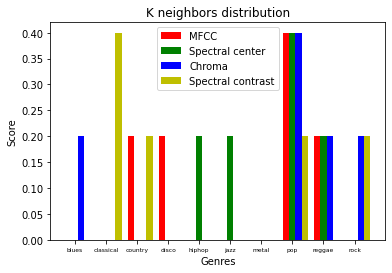

In [10]:

def menu():
    """
    Function that shows the user the example audios to try the model
    
    Returns:
        number of the audio chosen
    """
    print("""----Music genre clasifier KNN---- 
We have some example audio for you to try our genre guesser
1: classical_music.mp3
2: country_music.mp3
3: disco_music.mp3
4: hip-hop_music.mp3
5: jazz_music.mp3
6: metal_music.mp3
7: pop_music.mp3
8: reggae_music.mp3
9: 2pac-Hit'em up (HipHop)
10: Chopin - Nocturne op.9 No.2 (Classical)
11: Olivia Rodrigo - drivers license (pop)
12: ACDC - Highway to Hell
13: I will survive-Gloria Gaynor
14: Is this love bob marley
    """)
    n = int(input("Your choice:"))
    return n
    
 
def extract_audio_features(list_of_audiofiles):
    """
    Function that given a list of audio files extracts it features using librosa library
    
    Args:
        list_of_audiofiles: list of paths to audiofiles, list with no length restriction
        
    Returns:
        data: 3-dimensional numpy matrix of size number of audiofiles x 128 x 33, stores the audio features
        
        
    """
    data = np.zeros(
        (len(list_of_audiofiles), 128, 33), dtype=np.float64
    )

    for i, file in enumerate(list_of_audiofiles):
        y, sr = librosa.load(file)
        mfcc = librosa.feature.mfcc(
            y=y, sr=sr, hop_length=512, n_mfcc=13
        )
        spectral_center = librosa.feature.spectral_centroid(
            y=y, sr=sr, hop_length=512
        )
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
        spectral_contrast = librosa.feature.spectral_contrast(
            y=y, sr=sr, hop_length=512
        )
        
        data[i, :, 0:13] = mfcc.T[0:128, :]
        data[i, :, 13:14] = spectral_center.T[0:128, :]
        data[i, :, 14:26] = chroma.T[0:128, :]
        data[i, :, 26:33] = spectral_contrast.T[0:128, :]

        print(
            "Extracted features audio track %i of %i."
            % (i + 1, len(list_of_audiofiles))
        )

    return data
                
                
def get_values(neighbors_mfcc, neighbors_sce, neighbors_chroma, neighbors_sco, train_genre, k):
    """
    Functions that given the list of neighbors for each feature prepares the data to be graphed according to the proportions
    
    Args:
        neighbors_mfcc: list of size k x 2 (int x int), contains the k nearest neighbors according to mfcc and its distance 
        neighbors_sce: list of size k x 2 (int x int), contains the k nearest neighbors according to spectral center and its distance 
        neighbors_chroma: list of size k x 2 (int x int), contains the k nearest neighbors according to chroma and its distance 
        neighbors_sco: list of size k x 2 (int x int), contains the k nearest neighbors according to spectral contrast and its distance 
        train_genre: 2-dimensional numpy matrix of size: number of train audiofiles x 10, that stores the genre of each audio
        k: integer, number of neighbors allowed
    Returns:
        values: list of 4 lists for each of the audio features (mfcc, sce, chroma, sco), each one contains 10 values
                between 0 and 1 representing the proportion of the k neigbors found for that genre using that feature
    """
    values=[]
    for neighbors in [neighbors_mfcc, neighbors_sce, neighbors_chroma, neighbors_sco]:
        genre = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        for x in range(len(neighbors)):
            neighbor_genre_list = train_genre[neighbors[x][0]]
            count=0
            for i in neighbor_genre_list:
                if i == 1:
                    break
                else:
                    count+=1
            genre[count]=genre[count]+1
        for i in range(10):
            genre[i]=genre[i]/k
        values.append(genre)
        
    return values


def grafic_neighbors(values):
    """
    Function that graphs the proportion of neighbors for each feature using matplotlib
    
    Args:
        values: list of 4 lists for each of the audio features (mfcc, sce, chroma, sco), each one contains 10 values
                between 0 and 1 
                
        
    """
    N = 10
    ind = np.arange(N) 
    width = 0.2
    
    bar1 = plt.bar(ind, values[0], width, color = 'r')
    
    bar2 = plt.bar(ind+width, values[1], width, color='g')
    
    bar3 = plt.bar(ind+width*2, values[2], width, color = 'b')
    
    bar4 = plt.bar(ind+width*3, values[3], width, color = 'y')
    plt.xticks(fontsize=6)
    
    plt.xlabel("Genres")
    plt.ylabel('Score')
    plt.title("K neighbors distribution")
    
    plt.xticks(ind+width,["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"])
    plt.legend( (bar1, bar2, bar3, bar4), ('MFCC', 'Spectral center', 'Chroma', 'Spectral contrast') )
    plt.show()

 
def main():
    """
    Function that executes the menu and uses the model to show the user the obtained results
          
        
    """
    k=5
    exa= ["classical_music.wav", "country_music.wav", "disco_music.mp3", "hip-hop_music.mp3", "jazz_music.mp3", "metal_music.mp3", "pop_music.wav", "reggae_music.wav", "2pac-Hit'em up.mp3", "Chopin - Nocturne op.9 No.2.mp3", "Olivia Rodrigo - drivers license.mp3", "ACDC - Highway to Hell.mp3", "I will survive-Gloria Gaynor.mp3", "Is this love bob marley.mp3"]
    n = menu()
    file = [dir+"ExampleAudios/"+exa[n-1]]
    data=extract_audio_features(file)
    train_data, train_genre, test_data, test_genre = load_deserialize_data()
    prediction=[]
    neighbors_mfcc, neighbors_sce, neighbors_chroma, neighbors_sco=get_neighbors(train_data, train_genre, data[0], k)
    guess_genre=nearest_class(neighbors_mfcc, neighbors_sce, neighbors_chroma, neighbors_sco, train_genre)
    print(guess_genre)
    values=get_values(neighbors_mfcc, neighbors_sce, neighbors_chroma, neighbors_sco, train_genre, k)
    grafic_neighbors(values)

main()